In [1]:
import numpy as np
from PIL import Image
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import cv2
import time

In [2]:
kernel_code = """
__global__ void MatrixMulKernel(float* M, float* N, float* P, int Width)
{
    int Row = blockIdx.y * blockDim.y + threadIdx.y;
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    if ((Row < Width) && (Col < Width))
    {
        float Pvalue = 0;
        for (int k = 0; k < Width; ++k)
        {
            Pvalue += M[Row*Width+k] * N[k*Width+Col];
        }
        P[Row*Width+Col] = Pvalue;
    }
}
"""

In [3]:
Cols_Dim = 1024
Rows_Dim = 1024

In [4]:
M = np.random.rand(Rows_Dim, Cols_Dim).astype(np.float32)
N = np.random.rand(Rows_Dim, Cols_Dim).astype(np.float32)

In [5]:
d_M = cuda.mem_alloc(M.nbytes)
d_N = cuda.mem_alloc(N.nbytes)
d_P = cuda.mem_alloc(M.nbytes) # As they are square matrix, output bytes are the same

In [6]:
cuda.memcpy_htod(d_M, M)
cuda.memcpy_htod(d_N, N)

In [7]:
mod = SourceModule(kernel_code)
MatrixMulKernel = mod.get_function("MatrixMulKernel")

In [8]:
block_dim = (16, 16, 1)
grid_dim = ((Cols_Dim + block_dim[0] - 1) // block_dim[0], (Rows_Dim + block_dim[1] - 1) // block_dim[1])

In [9]:
start = time.time()
MatrixMulKernel(
    d_M,
    d_N,
    d_P,
    np.int32(Cols_Dim),
    block = block_dim,
    grid = grid_dim
)
end = time.time()
end - start

0.0010001659393310547

In [10]:
P = np.empty_like(M).astype(np.float32)

In [11]:
P.shape

(1024, 1024)

In [12]:
cuda.memcpy_dtoh(P, d_P)

In [13]:
M

array([[0.7523226 , 0.87685597, 0.26730734, ..., 0.35600927, 0.04345528,
        0.97789884],
       [0.06784651, 0.6633415 , 0.58676714, ..., 0.9282696 , 0.6970669 ,
        0.58003443],
       [0.59699094, 0.86833525, 0.56244254, ..., 0.23872581, 0.01751681,
        0.3325001 ],
       ...,
       [0.28337482, 0.74107283, 0.6807198 , ..., 0.08452909, 0.6273345 ,
        0.9198924 ],
       [0.7632179 , 0.7184023 , 0.06129909, ..., 0.586647  , 0.44267297,
        0.92062485],
       [0.46790928, 0.6059879 , 0.8203019 , ..., 0.08655137, 0.24525216,
        0.41440606]], dtype=float32)

In [14]:
N

array([[0.69166595, 0.9373464 , 0.80832475, ..., 0.4732505 , 0.22178836,
        0.70042086],
       [0.82272977, 0.2573309 , 0.63038015, ..., 0.64574397, 0.56313044,
        0.29750422],
       [0.6901964 , 0.9389744 , 0.5193235 , ..., 0.37564325, 0.19881023,
        0.9770811 ],
       ...,
       [0.37907422, 0.7030663 , 0.05601377, ..., 0.7080858 , 0.4405653 ,
        0.9622752 ],
       [0.93179715, 0.06601638, 0.9254286 , ..., 0.03345892, 0.83917624,
        0.8788791 ],
       [0.340655  , 0.8784838 , 0.82741445, ..., 0.5359862 , 0.81463706,
        0.4986453 ]], dtype=float32)

In [15]:
P

array([[259.5832 , 256.17377, 255.46577, ..., 261.4996 , 249.41052,
        250.4448 ],
       [260.29617, 252.896  , 254.83054, ..., 260.99158, 255.04163,
        255.5616 ],
       [249.12778, 247.04103, 241.67972, ..., 254.25883, 241.18613,
        245.64659],
       ...,
       [259.11435, 259.78333, 257.31998, ..., 266.7442 , 254.92322,
        260.52505],
       [247.6758 , 245.5557 , 243.39954, ..., 252.8442 , 244.16756,
        246.98042],
       [259.68442, 254.776  , 263.66992, ..., 265.46362, 256.34207,
        259.681  ]], dtype=float32)

In [16]:
start = time.time()
X = np.matmul(M,N).astype(np.float32)
end = time.time()
end - start

0.010000944137573242

In [17]:
X

array([[259.5831 , 256.1736 , 255.46594, ..., 261.49948, 249.41045,
        250.44481],
       [260.29584, 252.89607, 254.83081, ..., 260.9915 , 255.04184,
        255.56178],
       [249.12784, 247.04121, 241.67976, ..., 254.25891, 241.18613,
        245.64653],
       ...,
       [259.1142 , 259.78336, 257.3201 , ..., 266.74435, 254.92316,
        260.5251 ],
       [247.676  , 245.5556 , 243.39961, ..., 252.84422, 244.16734,
        246.98035],
       [259.68433, 254.77611, 263.66998, ..., 265.4637 , 256.34198,
        259.68127]], dtype=float32)

In [18]:
Z = P - X

In [19]:
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)
Z[0,:Rows_Dim]

array([ 0.0000915527,  0.0001525879, -0.0001678467, ...,  0.0001220703,
        0.0000762939, -0.0000152588], dtype=float32)

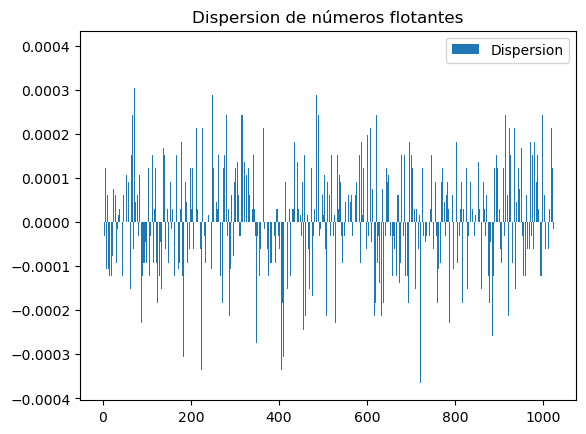

In [20]:
n = Rows_Dim
indices = np.arange(n)
x = np.arange(n)
y = Z[0,:n]
plt.bar(x, y, label='Dispersion')
plt.legend(loc='best')
plt.title('Dispersion de números flotantes')
plt.show()